# Req

deeper dive into:
[original source](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-contradictory-dearwatson)

In [65]:
!pip install -q keras-nlp --upgrade
!pip install seaborn
!pip install tensorflow==2.12.0
!pip install tensorflow-text

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.4.0 requires tensorflow~=2.12.0, but you have tensorflow 2.13.0 which is incompatible.
  Using cached tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: keras


In [3]:


import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)



2023-08-14 21:13:03.957215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 21:13:04.328854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 21:13:04.331499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 21:13:05.529423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend
TensorFlow version: 2.13.0
KerasNLP version: 0.6.1


# Code

In [4]:
 try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not activated")
    strategy = tf.distribute.MirroredStrategy() # Works on CPU, single GPU and multiple GPUs in a single VM.
    
print("replicas:", strategy.num_replicas_in_sync)

TPU not activated
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
replicas: 1


In [5]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

df_train = pd.read_csv('./csv/train.csv')
df_test = pd.read_csv('./csv/test.csv')

In [6]:
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [8]:
def display_pair_of_sentence(x):
  print("Premise : " + x['premise'])
  print("Hypothesis: " + x['hypothesis'])
  print("Language: " + x['language'])
  print("Label: " + str(x['label']))
  print()
    
df_train.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

df_train.shape

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

(12120, 6)

Text(0.5, 1.0, 'Distribution of labels in the training set')

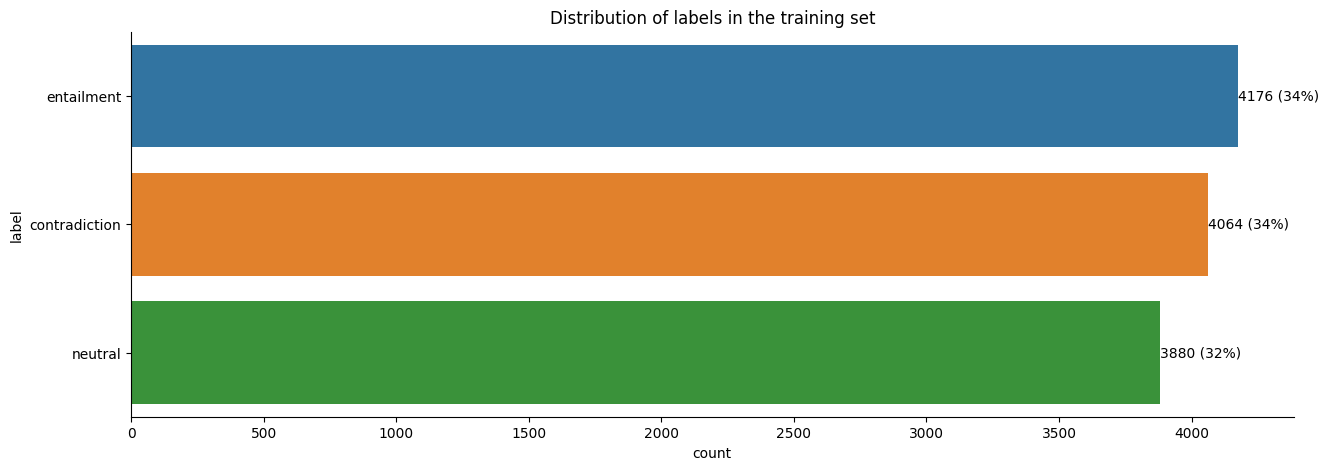

In [9]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5)) # f: figure, ax: axes

# Plot the total crashes
sns.set_color_codes(palette="muted") # what does palette do?
sns.despine() # removes top and right border
ax = sns.countplot(data=df_train, 
                   y="label",
                   order = df_train['label'].value_counts().index)

# this gets the exact  count of each 'label'
# the reason why ascending is false is because the plot is not in order
abs_values = df_train['label'].value_counts(ascending=False)

# normalize results and multiply by 100 to get percentages
rel_values = df_train['label'].value_counts(ascending=False, normalize=True).values * 100

# this just takes the two above lists and creates labels.
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)] 

# puts the labels on the plot
ax.bar_label(container=ax.containers[0], labels=lbls)

# translates 0, 1, 2 to their meaning using the earlier declared dict
ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

# sets title
ax.set_title("Distribution of labels in the training set")

In [10]:
df_train['label'].value_counts(ascending=False)

label
0    4176
2    4064
1    3880
Name: count, dtype: int64

In [11]:
df_train['label'].value_counts(ascending=False, normalize=True).values * 100

array([34.45544554, 33.53135314, 32.01320132])

Text(0.5, 1.0, 'Distribution of languages in the training set')

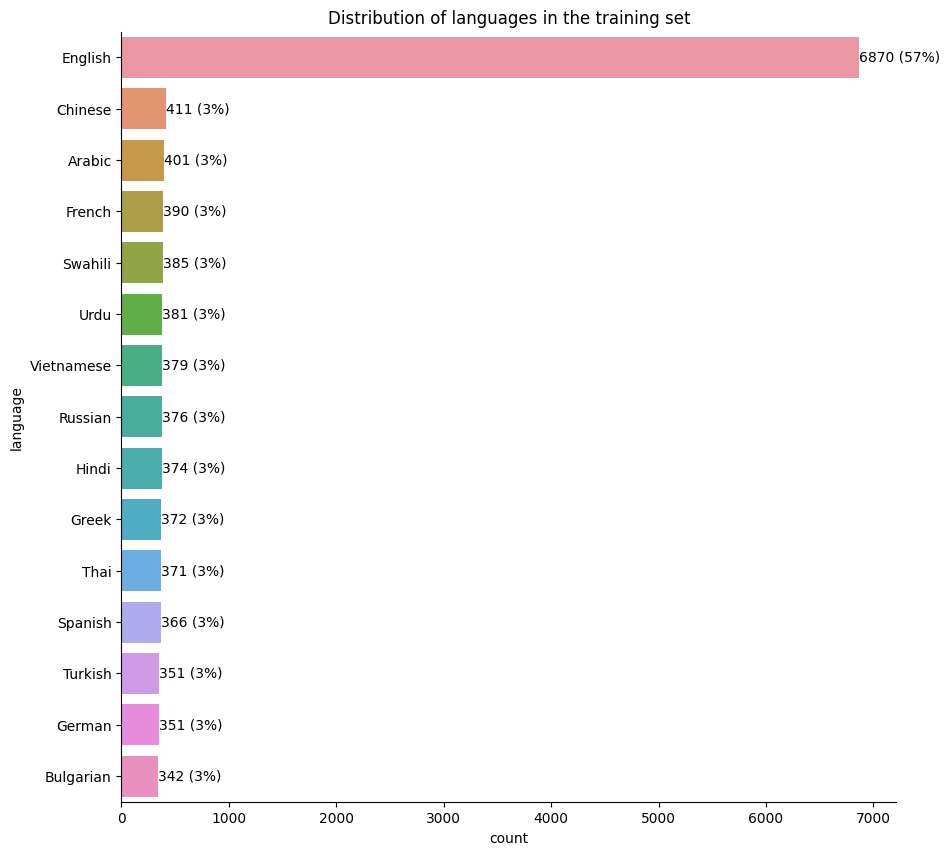

In [12]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
# literally does not change anything the coloring ???
sns.set_color_codes("colorblind") 
sns.despine()
ax = sns.countplot(data=df_train, 
                   y="language",
                   order = df_train['language'].value_counts().index)

# i like this technique of gettting counts and percentages
abs_values = df_train['language'].value_counts(ascending=False)
rel_values = df_train['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [13]:
df_train["premise_length"] = df_train["premise"].apply(lambda x : len(x))
df_train["hypothesis_length"] = df_train["hypothesis"].apply(lambda x : len(x))
df_train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,53.892327,107.373185
std,25.302358,71.089954
min,4.000000,4.000000
25%,36.000000,55.000000
50%,51.000000,96.000000
75%,67.000000,146.000000
max,276.000000,967.000000


In [14]:
VALIDATION_SPLIT = 0.3
print(df_train.shape[0])
TRAIN_SIZE = int(df_train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

12120


In [15]:
def split_labels(x, y):
  return (x[0], x[1]), y


training_dataset = (
  tf.data.Dataset.from_tensor_slices(
    (
      df_train[['premise','hypothesis']].values,
      keras.utils.to_categorical(df_train['label'], num_classes=3)
    )
  )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [16]:
# Load a BERT model.

with strategy.scope():
  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", num_classes=3)

  # in distributed training, the recommendation is to scale batch size and learning rate with the number of workers.
  classifier.compile(optimizer=keras.optimizers.Adam(1e-5*strategy.num_replicas_in_sync),
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
  classifier.summary()

2023-08-14 21:13:34.723820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 367248384 exceeds 10% of free system memory.
2023-08-14 21:13:35.002150: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 367248384 exceeds 10% of free system memory.
2023-08-14 21:13:35.102243: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 367248384 exceeds 10% of free system memory.


711647480/711647480 [==============================] - 23s 0us/step


2023-08-14 21:14:05.972781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 367248384 exceeds 10% of free system memory.


Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                             119,547 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ segment_ids (InputLayer)                      │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ bert_backbone (BertBackbone)                  │ {sequence_output: (None, None, 768),   │     177,853,440 │
│                                               │ pooled_output: (None, 768)}            │                 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ dropout (Dropout)                             │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 3)                              │           2,307 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 177,855,747 (5.30 GB)

 Trainable params: 177,855,747 (5.30 GB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS=3
history = classifier.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed
                        )

2023-08-14 21:15:16.177982: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 12120
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
   

Epoch 1/3


2023-08-14 21:15:21.626697: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 367248384 exceeds 10% of free system memory.
2023-08-14 21:16:34.665850: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at einsum_op_impl.h:531 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu


ResourceExhaustedError: Graph execution error:

Detected at node 'bert_classifier/bert_backbone/transformer_layer_7/multi_head_attention/einsum/Einsum' defined at (most recent call last):
    File "/usr/lib/python3.9/threading.py", line 912, in _bootstrap
      self._bootstrap_inner()
    File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
      self.run()
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras_nlp/src/layers/modeling/transformer_encoder.py", line 195, in call
      x = self._self_attention_layer(
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/layers/attention/multi_head_attention.py", line 598, in call
      attention_output, attention_scores = self._compute_attention(
    File "/home/layth/.local/lib/python3.9/site-packages/keras/src/layers/attention/multi_head_attention.py", line 527, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key, query)
Node: 'bert_classifier/bert_backbone/transformer_layer_7/multi_head_attention/einsum/Einsum'
OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node bert_classifier/bert_backbone/transformer_layer_7/multi_head_attention/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_37780]